In [91]:
import pydot
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from IPython.core.display import display
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [179]:
class FeaturesTools():
    def __init__(self, df, label_name, train_fraction = 0.7, random_seed = np.random.randint(low = 0, high = np.iinfo(np.int32).max)):
        self.df             = df
        self.random_seed    = random_seed
        self.train_fraction = train_fraction
        self.label_name     = label_name
        for key, value in self.split_df(self.df, self.label_name, self.train_fraction, self.random_seed):
            setattr(self, key, value)
    
    def split_df(self, df, label_name, train_fraction, random_seed):
        np.random.seed(random_seed)
        
        msk = np.random.rand(df.shape[0]) < train_fraction
        
        train_label = ['train_label', df[msk][label_name].reset_index(drop = True)]
        train_set   = ['train_set',   df[msk].drop(label_name, axis = 1).reset_index(drop = True)]
        test_label  = ['test_label',  df[~msk][label_name].reset_index(drop = True)]
        test_set    = ['test_set',    df[~msk].drop([label_name], axis = 1).reset_index(drop = True)]
    
        
        return [train_label, train_set, test_label, test_set]
    
    def normalize_features(self, df = None):
        if df is None:
            df = self.df
        norm = df.DataFrame(preprocessing.normalize(data, axis = 0)) 
        norm.columns = df.columns
        return norm
    
    def standardize_features(self, df = None):
        if df is None:
            df = self.df
        scaler = StandardScaler()
        scaled = scaler.fit_transform(df.values)
        scaled.columns = df.columns
        return scaled
    
    def importance_df(self, column_names, importances, std):
        df_importance = pd.DataFrame({'feature': column_names,
                           'feature_importance': importances,
                           'std' : std}) \
               .sort_values('feature_importance', ascending = False) \
               .reset_index(drop = True)
        return df_importance
    
    def randomForestAnalysis(self, train_data = None, train_labels = None, test_data = None, test_labels = None, 
                             seed = None, n_trees = 500, plotResults = False, plotTree = False, tuneModelParameters = False):
        print('> Running randomForestAnalysis...\n')
        
        if train_data is None:
            train_data = self.train_set
        if train_labels is None:
            train_labels = self.train_label
        if test_data is None:
            test_data = self.test_set
        if test_labels is None:
            test_labels = self.test_label
        if seed is None:
            seed = self.random_seed
        
        # advantage of the random forest:
        # The random forest performs implicit feature selection because it splits nodes on the most important variables.
        # The random forest feature importances can be used to reduce the number of variables in the problem.
        # In addition to potentially increasing performance, reducing the number of features will shorten the run time of the model.
        #
        # Other more complex dimensionality reductions methods (do a good job of decreasing the number of features while not decreasing 
        # information, but they transform the features such that they no longer represent our measured variables):
        # > PCA
        # > ICA
        
        # tune the model hyperparameters to run the best model. 
        # Use Random Search Training: not every combination is tested, but some are selected at random to sample a wide range of values.
        # Otherwise: too long!
        if tuneModelParameters:
            # Number of trees in random forest
            n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2100, num = 21)]
            # Number of features to consider at every split
            max_features = ['auto', 'sqrt']
            # Maximum number of levels in tree
            max_depth = [int(x) for x in np.linspace(1, 111, num = 20)]
            max_depth.append(None)
            # Minimum number of samples required to split a node
            min_samples_split = [2, 5, 10]
            # Minimum number of samples required at each leaf node
            min_samples_leaf = [1, 2, 4]
            # Method of selecting samples for training each tree
            bootstrap = [True, False]
            # Create the random grid
            random_grid = {'n_estimators': n_estimators,
                           'max_features': max_features,
                           'max_depth': max_depth,
                           'min_samples_split': min_samples_split,
                           'min_samples_leaf': min_samples_leaf,
                           'bootstrap': bootstrap}
            
            # Random grid to search for best hyperparameters
            # First create the base model to tune
            rf = RandomForestRegressor()
            # Random search of parameters, using 4 fold cross validation
            rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
            # Fit the random search model
            rf_random.fit(train_data, train_labels)
            
            rf = rf_random.best_estimator_
            
            # select one tree for visualization
            visual_tree = rf_random.best_estimator_[1]
        else:
            # > n_estimators = number of trees in the forest
            # > The criterion is by default mse
            # > n_jobs = -1 to use all the processors if multicore cpu
            # > set random_state (random seed) to 1 for reproducibility
            # > OOB is the out-of-bag score, computed on the leaved-out samples when using bootstrapping. If true, use out-of-bag samples 
            #   to estimate the R^2 on unseen data.
            rf = RandomForestRegressor(n_estimators = 100,
                                       n_jobs = -1,
                                       oob_score = True,
                                       bootstrap = True,
                                       random_state = seed)
            
            
            rf.fit(train_data, train_labels)
            
            # select one tree for visualization
            visual_tree = rf.estimators_[1]
        
        # predictions on test data:
        predictions = rf.predict(test_data)
        
        # average absolute error:
        errors = abs(predictions - test_labels)
        
        # mean absolute percentage error (MAPE)
        mape = np.mean(100 * (errors / test_labels))
        
        # build df with features importance
        importance = rf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
        df_importance = self.importance_df(train_data.columns, importance, std)
        
        # cumulative importance
        cumulative_importance = df_importance['feature_importance'].cumsum()
        
        # No overfit is observed if the OOB score and the Test (Validation) score are very similar
        
        print('> randomForestAnalysis results...')
        print('R^2 Training Score:     %f' %(rf.score(train_data, train_labels)))
        print('R^2 OOB Score:          %f' %(rf.oob_score_))
        print('R^2 Test Score:         %f' %(rf.score(test_data, test_labels)))
        print('Average absolute error: %f units' %(round(np.mean(errors), 2)))
        print('Accuracy:               %f%%\n\n' %(round(100 - mape, 2)))
        #print("Feature ranking:")
        #display(df_importance)

        
        if plotResults:
            # error bars are so small that are not visible
            sns.barplot(x = 'feature_importance', y = 'feature', data = df_importance, orient = 'h', ci = 'sd', capsize=.2)
            fig = plt.gcf()
            fig.set_size_inches(20, 15)
            plt.xlabel('Feature Importance', size = 22)
            plt.ylabel('Feature', size = 22)
            plt.tick_params(labelsize = 10)
            plt.show()
        
        
            # plot Cumulative importance.
            x_values = np.arange(0, len(cumulative_importance))
            plt.plot(x_values, cumulative_importance, 'g-')
            fig = plt.gcf()
            fig.set_size_inches(20, 6)
            # Draw line at 95% of importance retained
            l1 = plt.hlines(y = 0.95, xmin = 0, xmax = len(cumulative_importance), color = 'r', linestyles = 'dashed')
            ax = plt.gca()
            ax.set_xticks(x_values)
            ax.set_xticklabels(df_importance.feature, rotation = 45, ha = 'right')
            plt.xlabel('feature', size = 22); 
            plt.ylabel('Cumulative Importance', size = 22); 
            plt.tick_params(labelsize = 10)
            plt.legend([l1], ['95% threshold'], loc = 'center right', fontsize = 20)
            plt.show()
            
            if plotTree:
                # visualize the tree
                export_graphviz(visual_tree, out_file = './RandomTree.dot', feature_names = train_data.columns, 
                    precision = 2, filled = True, rounded = True, max_depth = None)
                (graph, ) = pydot.graph_from_dot_file('./RandomTree.dot')
                graph.write_png('./RandomTree.png')
            

                # Limit depth of tree to 3 levels
                # rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
                # rf_small.fit(train_features, train_labels)
                # Extract the small tree
                # tree_small = rf_small.estimators_[5]
                # Save the tree as a png image
                # export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
                # (graph, ) = pydot.graph_from_dot_file('small_tree.dot')
                # graph.write_png('small_tree.png');
        
        return df_importance
            
            
    def correlationAnalysis(self, df = None, method = 'pearson', plotMatrix = True, printMaxCorr = True):
        print('> Running correlationAnalysis...\n')
        if df is None:
            df = self.df
            
        corr = df.corr(method = 'pearson')

        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        
        if plotMatrix:
            chart = sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=True, yticklabels=True)
            fig = plt.gcf()
            fig.set_size_inches(20, 20)
            plt.tick_params(labelsize=10)
            chart.set_xticklabels(
                chart.get_xticklabels(), 
                rotation=45, 
                horizontalalignment='right')
            plt.title('Features correlation matrix - ' + method, fontsize = 22, \
                      fontweight='bold')
            plt.show()
        
        # print: variable... is max correlated with....
        #if printMaxCorr:
            #pass

        return corr
    
    
    def word_cloud(self, mask_file_path, df_importance, out_image_name):
        
        mask = np.array(Image.open(mask_file_path))
        
        text = [w.replace('_', ' ') for w in df_importance.feature.tolist()]
        wext_weight = {}
        for key, weight in zip(text, df_importance.feature_importance.tolist()):
            wext_weight[key] = weight
        
        wc = WordCloud(background_color = 'black', max_words = 1000, mask = mask, contour_color = '#FB404D',
                      contour_width = 2).generate_from_frequencies(wext_weight)
        #wc.to_file('./' + out_image_name + '.png')
        plt.figure(figsize=[20,10])
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.savefig('./' + out_image_name + '.png')
        plt.show()
        
        
    

        
    

In [56]:
class CleaningUtility():
    def __init__(self):
        pass
    
    def bool_to_int(self, df, columns_names):
        print('> Running bool_to_int...')
        map_bool = {'t':1, 'f':0, 'nan':np.nan}
        dict_replace = {}
        for col in columns_names:
            dict_replace.update({col : map_bool})

        df[columns_names] = df[columns_names].astype('str').replace(dict_replace)

        # test conversion
        all_is_num = df[columns_names].notnull().all()
        unique_values = np.unique(df[columns_names].values)
        if all_is_num.all() & (set([0, 1]) == set(unique_values)):
            print('All boolean correctly converted')
        elif np.isnan(unique_values).any():
            print('All boolean correctly converted but some nan are present\n')

        return df

    def host_activity_period(self, df, column):
        print('> Running host_activity_period...')
        df[column] = 2019 - pd.DatetimeIndex(df[column]).year

        unique_values = df[column].unique()
        if np.isnan(unique_values).any():
            print('All activities periods extracted but some nan are present\n')
        return df

    def list_to_number_of_services(self, df, columns, drop_col = True):
        print('> Running list_to_number_of_services...')
        for col in columns:
            df['number_of_' + col] = df[col].apply(lambda x: len(x.replace('"', '').replace('{', '').replace('}', '').split(',')))
            if drop_col:
                df = df.drop(col, axis = 1) 
        return df

    def convert_to_one_hot_label(self, df, columns):
        print('> Running convert_to_one_hot_label...')
        df = pd.get_dummies(df, prefix = columns, columns = columns)
        return df

    def replace_nan_by_values(self, df, columns_list, values_list):
        print('> Running replace_nan_by_values...')
        value_replace = {}
        for col, val in zip(columns_list, values_list):
            value_replace.update({col:val})
        df[columns_list] = df[columns_list].fillna(value = value_replace)
        return df

    def format_price(self, df, columns_list):
        print('> Running format_price...')
        for col in columns_list:
            # replace , in price by '' and remove $ if present (ex $658,000.0)
            df[col] = df[col].apply(lambda x: x.replace(',', '').split('$')[1] if (type(x) is str and '$' in x) else x)
        return df

    def format_rate(self, df, columns_list):
        print('> Running format_rate...')
        for col in columns_list:
            df[col] = df[col].apply(lambda x: x.split('%')[0] if (type(x) is str and '%' in x) else x)
        return df

    # convert strings in df column df_column_name to id in reference_IDs associated to the reference_strings
    def string_to_id(self, df, df_column_name, reference_strings, reference_IDs):
        print('> Running string_to_id...')
        id_replace = {}
        for ref_s, ref_id in zip(reference_strings, reference_IDs):
            id_replace.update({ref_s:ref_id})
        df[df_column_name] = df[df_column_name].replace(id_replace)
        return df

    def prices_per_person(self, df, price_columns, nb_persons_column):
        print('> Running prices_per_person...')
        df[price_columns] = df[price_columns].astype('float64')
        df[nb_persons_column] = df[nb_persons_column].astype('float64')
        for p_c in price_columns:
            df[p_c + '_per_person'] = df[p_c] / df[nb_persons_column]
        return df

    def select_numeric_column_only(self, df):
        print('> Running select_numeric_column_only...')
        df = df[df.notnull().any(axis=1)]
        return df


In [181]:
input_csv_file      = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/2019-09-14_Amsterdam_listings_detailed.csv'
neighbourhoods_file = '/Volumes/Disk2/Courses MA3/MA3 - ADA/AIRBNB data/DataSet/NaT_Amsterdam_neighbourhoods.csv'
mask_file           = '/Volumes/Disk2/Courses MA3/MA3 - ADA//airbnb_ada_project/img/house_mask.png'


df       = pd.read_csv(input_csv_file, low_memory = False);
neigh_df = pd.read_csv(neighbourhoods_file)

neigh_df['neighborhood_id'] = neigh_df.index.values + [1]*neigh_df.shape[0]

#  review_scores_rating is calculated as weighted sum of other scores
selected_features       = ['host_since', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                          'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed',
                          'property_type', 'room_type', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee',
                          'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 
                          'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
                          'instant_bookable', 'cancellation_policy']

rating_features         = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
date_features           = 'host_since'
bool_features           = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
list_features           = ['host_verifications', 'amenities']
price_features          = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']
neighborhood_features   = ['neighbourhood_cleansed']
string_features         = ['property_type', 'cancellation_policy','room_type', 'bed_type']
rate_features           = ['host_response_rate']
replace_nan_features    = ['host_response_rate', 'host_is_superhost', 'host_total_listings_count', 'security_deposit', 
                           'number_of_amenities', 'cleaning_fee']
replace_values          = [0, 0, 0, 0, 0, 0]


cu       = CleaningUtility()
features = df[selected_features].copy()
features = cu.bool_to_int(features, bool_features)
features = cu.host_activity_period(features, date_features)
features = cu.list_to_number_of_services(features, list_features)
features = cu.format_price(features, price_features)
features = cu.format_rate(features, rate_features)
features = cu.replace_nan_by_values(features, replace_nan_features, replace_values)
# TODO: better to transform neigh into one-hot label instead as on ID to find the best quartier?
features = cu.string_to_id(features, neighborhood_features[0], neigh_df.neighbourhood, neigh_df.neighborhood_id)
# TODO: appropriate also for property_type or should create macro groups such as house, ... Same for room_type and bed_type
features = cu.convert_to_one_hot_label(features, string_features)
features = cu.prices_per_person(features, price_features[0:-1], 'guests_included')

# TODO: include for example length of host description? host_about > host_about_length
# TODO: include listing_duration = (last_review - first_review) in days?
# TODO: include hosting_duration = (last_review - host_since)  in days?
# TODO: use host_activity_period in days?

# list of IDs
# print('> The unique properties in the dataset are:')
# reference_strings = df['property_type'].unique()
# reference_IDs     = [0]
# print(reference_strings)

##############################################################
## now that all the data are numeric, convert all to float64 #
##############################################################
cols           = features.columns
features[cols] = features[cols].apply(pd.to_numeric, errors = 'raise')

##############################################################
############# keep only rows with non-nan values #############
##############################################################
tmp      = features.shape[0]
features = cu.select_numeric_column_only(features)
features = features.dropna()

##############################################################
##################### print cleaning info ####################
##############################################################
print('\nNumber of rows    before data set cleaning:       %.0f'%(df.shape[0]))
print(  'Number of rows    after data set cleaning:        %.0f'%(tmp))
print(  'Number of rows    after removal of rows with nan: %.0f'%(features.shape[0]))
print(  'Number of columns before data set cleaning:       %.0f'%(df.shape[1]))
print(  'Number of columns initially selected:             %.0f'%len(selected_features))
print(  'Number of columns after data set cleaning:        %.0f'%(features.shape[1]))

display(features.describe())
display(features.head())

> Running bool_to_int...
All boolean correctly converted but some nan are present

> Running host_activity_period...
All activities periods extracted but some nan are present

> Running list_to_number_of_services...
> Running format_price...
> Running format_rate...
> Running replace_nan_by_values...
> Running string_to_id...
> Running convert_to_one_hot_label...
> Running prices_per_person...
> Running select_numeric_column_only...

Number of rows    before data set cleaning:       20244
Number of rows    after data set cleaning:        20244
Number of rows    after removal of rows with nan: 17652
Number of columns before data set cleaning:       106
Number of columns initially selected:             29
Number of columns after data set cleaning:        75


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,price,security_deposit,cleaning_fee,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,price_per_person,security_deposit_per_person,cleaning_fee_per_person
count,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,...,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000,17652.000000
mean,4.379277,56.333730,0.173125,5.043904,0.999603,0.408679,11.391967,154.677770,159.321833,33.228813,...,0.192783,0.002549,0.000736,0.000227,0.001983,0.006118,0.990936,121.526966,120.385073,25.506871
std,1.965768,47.783352,0.378366,27.555681,0.019910,0.491604,6.177391,140.912024,322.756868,25.515365,...,0.394495,0.050427,0.027129,0.015052,0.044485,0.077982,0.094776,118.944494,270.232106,21.673675
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.000000,99.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,69.500000,0.000000,10.000000
50%,5.000000,90.000000,0.000000,1.000000,1.000000,0.000000,9.000000,130.000000,91.500000,35.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,100.000000,37.500000,22.500000
75%,6.000000,100.000000,0.000000,1.000000,1.000000,1.000000,18.000000,180.000000,250.000000,50.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,150.000000,150.000000,39.000000
max,11.000000,100.000000,1.000000,932.000000,1.000000,1.000000,22.000000,8915.000000,4489.000000,500.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8915.000000,4485.000000,500.000000


,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,price,security_deposit,cleaning_fee,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,price_per_person,security_deposit_per_person,cleaning_fee_per_person
0,11.0,100,1.0,1.0,1.0,0.0,15,59.0,200.0,60.0,...,1,0,0,0,0,0,1,59.0,200.0,60.0
1,10.0,100,0.0,2.0,1.0,0.0,5,80.0,0.0,0.0,...,1,0,0,0,0,0,1,40.0,0.0,0.0
2,10.0,100,0.0,2.0,1.0,0.0,6,125.0,300.0,40.0,...,0,0,0,0,0,0,1,62.5,150.0,20.0
3,9.0,100,1.0,1.0,1.0,1.0,6,155.0,0.0,0.0,...,1,0,0,0,0,0,1,155.0,0.0,0.0
4,9.0,100,1.0,3.0,1.0,1.0,6,75.0,0.0,0.0,...,1,0,0,0,0,0,1,75.0,0.0,0.0


> Running randomForestAnalysis...

> randomForestAnalysis results...
R^2 Training Score:     0.875201
R^2 OOB Score:          0.090328
R^2 Test Score:         0.087109
Average absolute error: 3.970000 units
Accuracy:               95.280000%




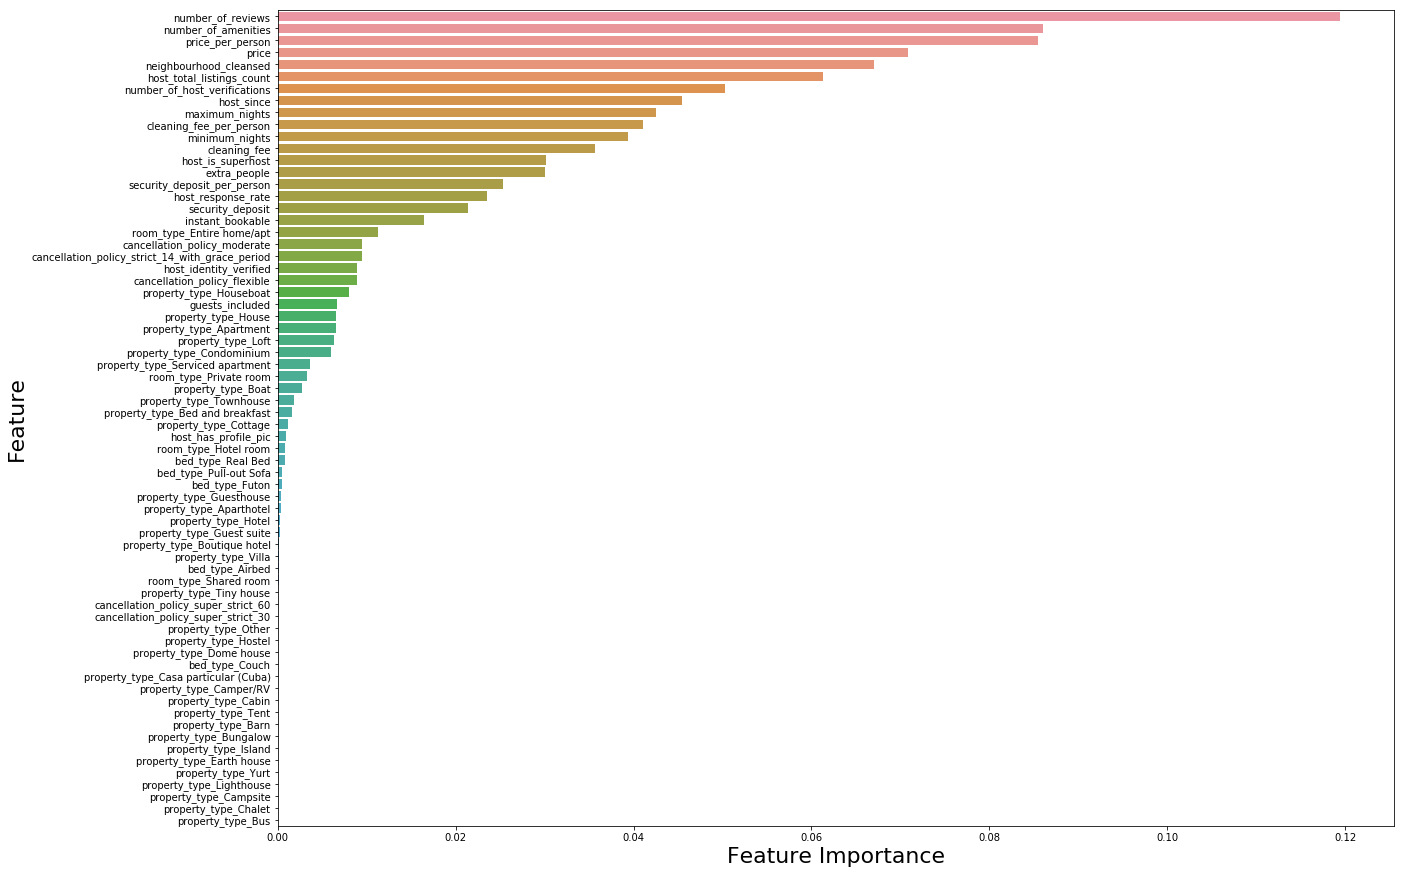

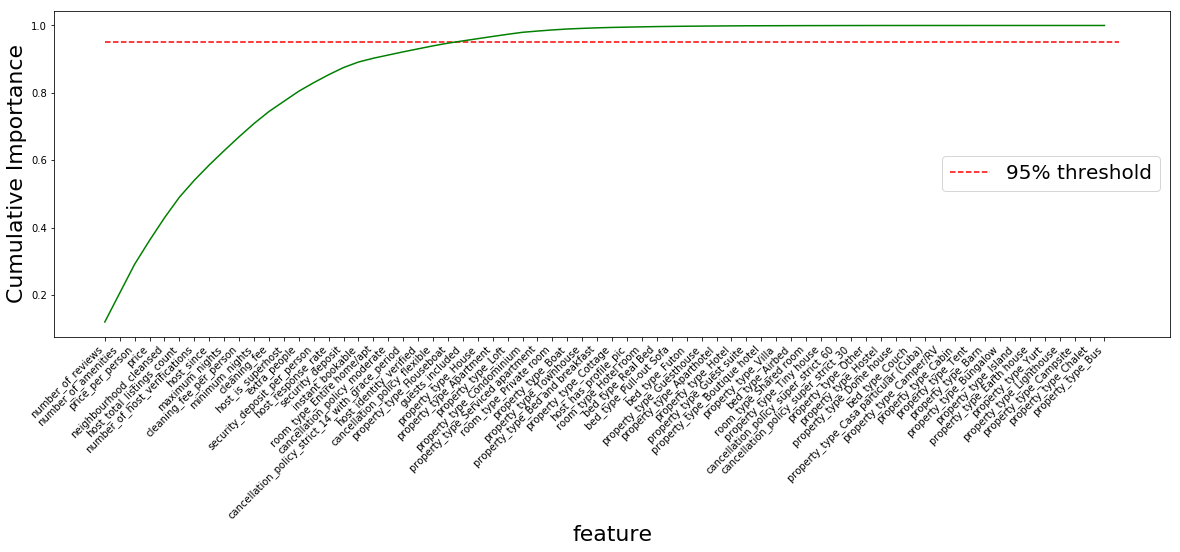

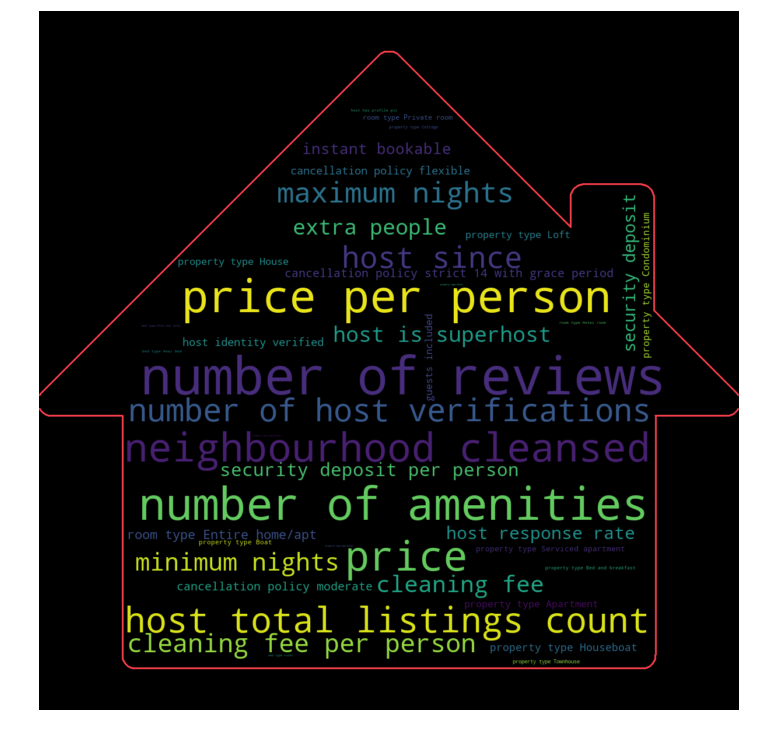

In [182]:
ff = FeaturesTools(features, 'review_scores_rating')

#corr = ff.correlationAnalysis(features, method = 'pearson')
#corr = ff.correlationAnalysis(features, method = 'spearman')

f1 = FeaturesTools(features[features.columns.difference(rating_features[1:])], rating_features[0])
imp1 = f1.randomForestAnalysis(plotResults = True, tuneModelParameters = False)

f1 = FeaturesTools(features[features.columns.difference(rating_features[1:])], rating_features[0])
f1.word_cloud(mask_file, imp1, 'TotalScore_Cloud')